## Import Packages

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import random
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.data.dataset import PerthTempAndRainfall
from ts.utility import Utility
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso

## Load Dataset

In [2]:
rainfall_df = PerthTempAndRainfall.loadData('/Users/ahmed/Downloads/Datasets/PerthTempAndRainfall')
rainfall_df

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality,Date
0,1944.0,6.0,3.0,11.0,22.3,0.0,N,1944-06-03
1,1944.0,6.0,4.0,12.2,23.4,0.0,Y,1944-06-04
2,1944.0,6.0,5.0,12.0,20.3,2.0,Y,1944-06-05
3,1944.0,6.0,6.0,7.4,18.7,3.3,Y,1944-06-06
4,1944.0,6.0,7.0,5.9,21.3,0.3,Y,1944-06-07
...,...,...,...,...,...,...,...,...
27642,1991.0,6.0,23.0,NaN,18.6,25.4,Y,None
27643,1997.0,1.0,1.0,NaN,43.5,0.0,Y,None
27644,1999.0,8.0,11.0,NaN,15.4,31.4,Y,None
27645,2018.0,5.0,26.0,NaN,18.8,27.4,N,None


### Get Rainfall Series

In [4]:
rainfall_series = rainfall_df['Rainfall amount (millimetres)'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}, '
    + f'Contains NaN: {np.isnan(rainfall_series).any()}')

Rainfall data: datatype: float64, shape: (27647,), Contains NaN: False


## Train-Test Split

In [74]:
train_frac = 0.90
num_train = int(n * train_frac)

print(f'Length of training series: {num_train}, '
     + f'Length of test series: {n - num_train}')

Length of training series: 24882, Length of test series: 2765


### Plot Entire Data

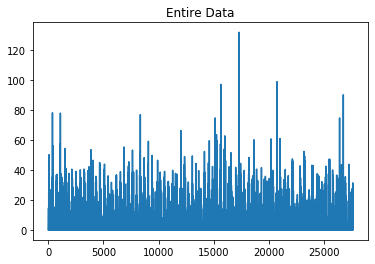

In [6]:
plt.plot(rainfall_series)
plt.title('Entire Data')
plt.show()

### All Data Histogram

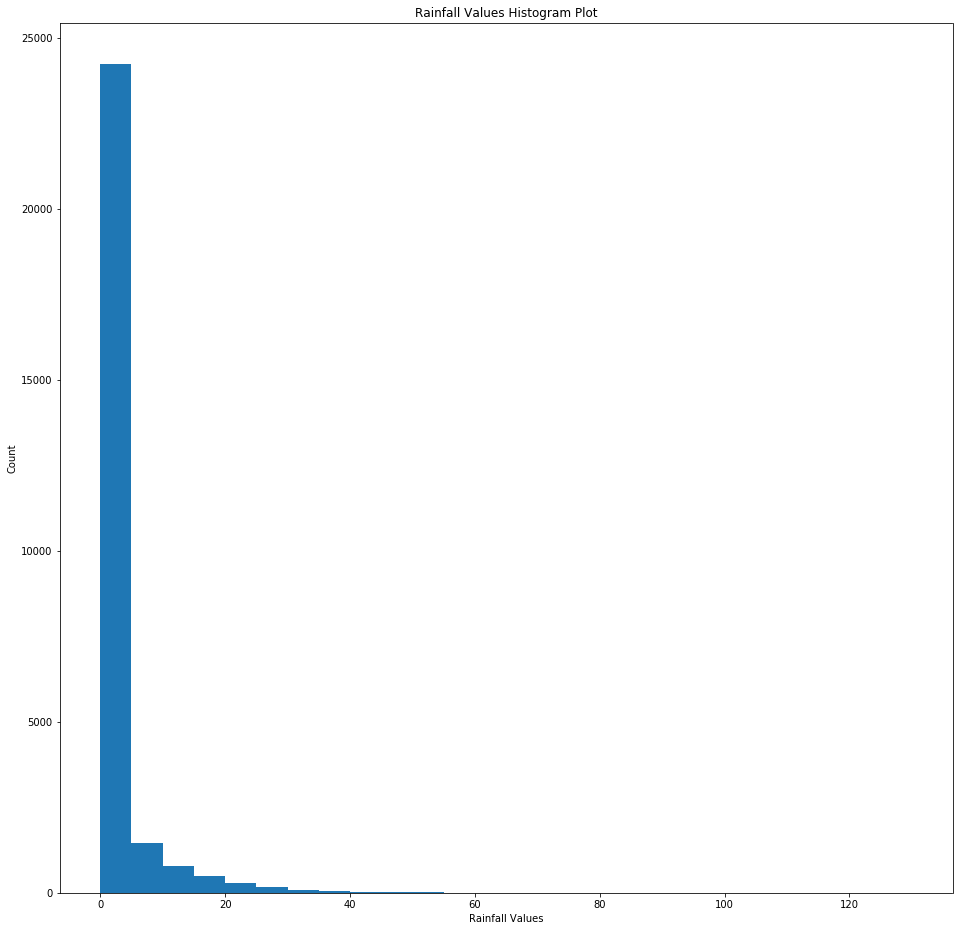

In [7]:
bin_width = 5
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

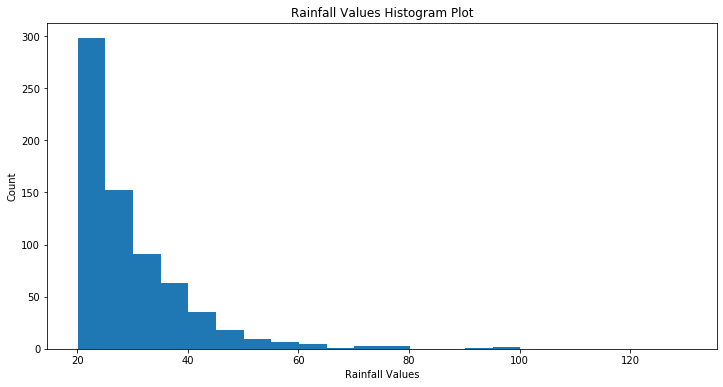

In [8]:
lower_bound = 20

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 5
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

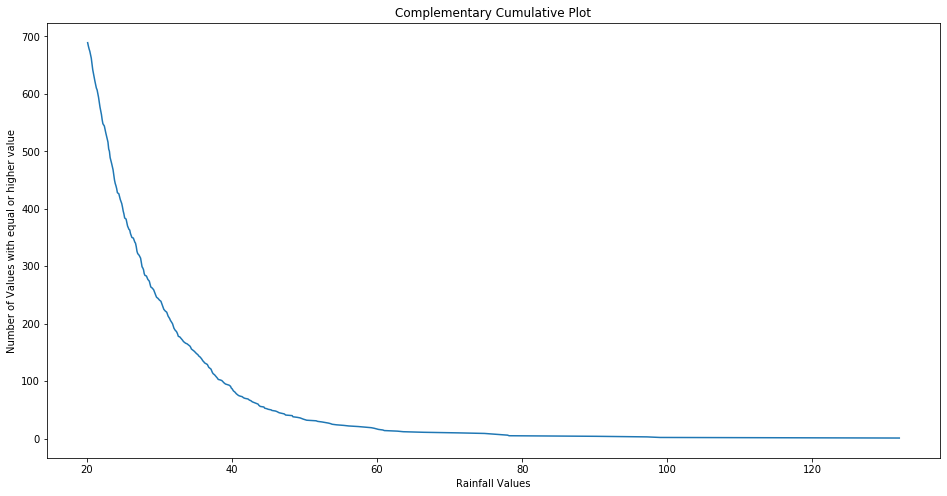

In [10]:
lower_bound = 20

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [11]:
threshold = 20 # Rainfall in mm

exceed_series = []

for i in range(num_train):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (604,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.10855840612874654 
Scale Parameter: 8.732771706736383 
Log Likelihood: -1978.4872986001062


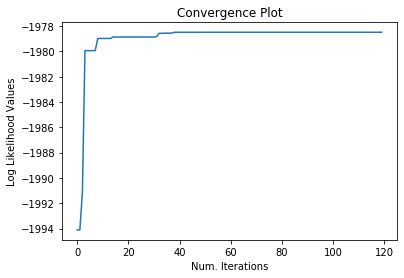

In [15]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 200),
    numIterations=120
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [16]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

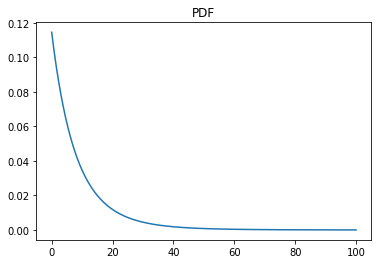

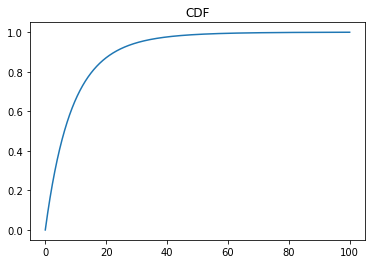

In [17]:
x = np.linspace(0, 100, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [56]:
lag = 50

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [65]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (601, 50)
Output Data: datatype: float64, shape: (601, 1)


In [66]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        11.4,  5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,
         0. , 41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,  0. ,
         0. ,  0. ,  0. , 34.3,  0.8,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4,  5.1, 19.3,  0. ,  0. ,
         0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. , 41.4,  1.8,  2.5,  0. ,
         3.8,  0.5,  0.5,  0.3,  0. ,  0. ,  0. ,  0. ,  0. , 34.3,  0.8,
         0. , 34.3,  6.1, 10.9,  0.8,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [26.9,  5.6,  0. ,  0. ,  0. ,  0. , 41.4,  1.8,  2.5,  0. ,  3.8,
         0.5,  0.5,  0.3,  0. ,  0. ,  0. ,  0. ,  0. , 34.3,  0.8,  0. ,
        34.3,  6.1, 10.9,  0.8,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 50.3,  9.1,  0. ,  0. ,  0. ,  0. ,
    

### Train the Model

Epoch 1/100
19/19 [==============================] - 0s 2ms/step - loss: 4.2201e-04
Epoch 2/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2189e-04
Epoch 3/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2180e-04
Epoch 4/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2168e-04
Epoch 5/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2158e-04
Epoch 6/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2147e-04
Epoch 7/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2137e-04
Epoch 8/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2129e-04
Epoch 9/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2121e-04
Epoch 10/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2112e-04
Epoch 11/100
19/19 [==============================] - 0s 1ms/step - loss: 4.2105e-04
Epoch 12/100
19/19 [==============================] - 0s 1ms/step - loss: 

19/19 [==============================] - 0s 1ms/step - loss: 4.1886e-04
Epoch 98/100
19/19 [==============================] - 0s 1ms/step - loss: 4.1886e-04
Epoch 99/100
19/19 [==============================] - 0s 2ms/step - loss: 4.1886e-04
Epoch 100/100
19/19 [==============================] - 0s 2ms/step - loss: 4.1885e-04


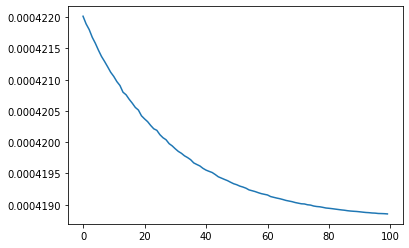

In [68]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [22]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (85, 50)
Output Test Data: datatype: float64, shape: (85, 1)

Test Loss (CDF): 0.13448944687843323
Test Loss (Actual): 161.95091247558594


## Part 2: Extreme Value Detection (Classification) Algorithm

In [140]:
class MlpEnsemble:
    
    def get_model(self, lag):
        
        model = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear'),
        ])
        
        model.build(input_shape=(None, lag))
        model.compile(
            optimizer=Adam(
                ExponentialDecay(
                    1e-3, 50, 0.9
                )
            ),
            loss=BinaryCrossentropy(from_logits=True)
        )
        
        return model
    
    def __init__(self, lag, num_models=10):
        
        self.models = [self.get_model(lag) for _ in range(num_models)]
        
    def train(self, input_data, output_data, each_model_epochs):
        
        pos_data = []
        neg_data = []
        
        for i in range(input_data.shape[0]):
            
            if output_data[i, 0] == 1:
                pos_data.append((input_data[i], output_data[i]))
                
            else:
                neg_data.append((input_data[i], output_data[i]))
        
        assert len(pos_data) < len(neg_data)
        
        losses = np.zeros(each_model_epochs)
        
        for model in self.models:
            
            data = pos_data.copy()
            data.extend(random.sample(neg_data, k=len(pos_data)))
            
            input_data, output_data = [], []
            for inp, out in data:
                input_data.append(inp)
                output_data.append(out)
                
            input_data = np.array(input_data)
            output_data = np.array(output_data)
        
            history = model.fit(
                input_data, 
                output_data, 
                epochs=each_model_epochs,
                verbose=0
            )
            
            losses += np.array(history.history['loss'])
                
        losses /= len(self.models)
        return losses
    
    def predict(self, input_data):
        
        num_pos = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        num_neg = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        
        for model in self.models:
            
            model_out = model.predict(input_data)
            model_pred = (tf.sigmoid(model_out).numpy() > 0.5) \
                .astype(np.int64)
            
            num_pos += model_pred
            num_neg += (1 - model_pred)
            
        pred = (num_pos > num_neg).astype(np.int64)
        return pred

In [141]:
model_detect = MlpEnsemble(lag=50, num_models=10)

### Build Training Data

In [142]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1)
    
    else:
        output_data.append(0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (24832, 50)
Output Data: datatype: int64, shape: (24832, 1)


In [143]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,
         0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. , 11.4,  5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,
         0. ,  0. , 41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,
         0. ,  0. ,  0. ,  0. , 34.3,  0.8],
       [ 0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        11.4,  5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,
         0. , 41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,  0. ,
         0. ,  0. ,  0. , 34.3,  0.8,  0. ],
       [ 2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4,
         5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. ,
        41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,  0. ,  0. ,
    

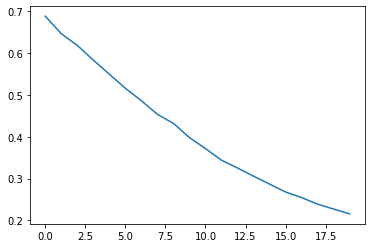

In [144]:
losses = model_detect.train(input_data, output_data, 20)
plt.plot(losses)

In [145]:
is_pos = output_data == 1.

num_true_pos = np.sum(model_detect.predict(input_data)[is_pos])
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(1 - model_detect.predict(input_data)[is_neg])
total_neg = np.sum(is_neg)

print(f'Train: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Train: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Train: True Pos: 581, Total Pos: 628
Train: True Neg: 16954, Total Neg: 24204


## Part 3: Normal Value Prediction Algorithm

In [28]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1.0)
    
    else:
        output_data.append(0.0)

input_data = np.array(input_data, dtype=np.float32)
output_data = np.expand_dims(np.array(output_data, dtype=np.float32), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_detect.predict(input_data)

test_loss = loss_func(true_val, pred_val)
print(f'Test Loss: {test_loss}')

Input Test Data: datatype: float32, shape: (4148, 50)
Output Test Data: datatype: float32, shape: (4148, 1)

Test Loss: 1.6203299760818481


In [29]:
is_pos = output_data == 1.

num_true_pos = np.sum(tf.sigmoid(model_detect.predict(input_data)[is_pos]).numpy() > 0.5)
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(tf.sigmoid(model_detect.predict(input_data)[is_neg]).numpy() <= 0.5)
total_neg = np.sum(is_neg)

print(f'Test: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Test: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Test: True Pos: 85, Total Pos: 85
Test: True Neg: 0, Total Neg: 4063


In [30]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [31]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (22848, 50)
Output Data: datatype: float64, shape: (22848, 1)


In [32]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,
         0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. , 11.4,  5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,
         0. ,  0. , 41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,
         0. ,  0. ,  0. ,  0. , 34.3,  0.8],
       [ 2. ,  3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4,
         5.1, 19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. ,
        41.4,  1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,  0. ,  0. ,
         0. ,  0. , 34.3,  0.8,  0. , 34.3],
       [ 3.3,  0.3,  0. ,  0. ,  0. ,  9.9, 10.2, 14.7,  0.8,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 11.4,  5.1,
        19.3,  0. ,  0. ,  0. , 26.9,  5.6,  0. ,  0. ,  0. ,  0. , 41.4,
         1.8,  2.5,  0. ,  3.8,  0.5,  0.5,  0.3,  0. ,  0. ,  0. ,  0. ,
    

Epoch 1/100
714/714 [==============================] - 1s 2ms/step - loss: 10.7859
Epoch 2/100
714/714 [==============================] - 1s 854us/step - loss: 10.4174
Epoch 3/100
714/714 [==============================] - 1s 751us/step - loss: 10.2692
Epoch 4/100
714/714 [==============================] - 1s 701us/step - loss: 10.2336
Epoch 5/100
714/714 [==============================] - 1s 746us/step - loss: 10.2235
Epoch 6/100
714/714 [==============================] - 1s 1ms/step - loss: 10.2213
Epoch 7/100
714/714 [==============================] - 1s 1ms/step - loss: 10.2208
Epoch 8/100
714/714 [==============================] - 1s 1ms/step - loss: 10.2207
Epoch 9/100
714/714 [==============================] - 1s 2ms/step - loss: 10.2206
Epoch 10/100
714/714 [==============================] - 1s 709us/step - loss: 10.2206
Epoch 11/100
714/714 [==============================] - 0s 684us/step - loss: 10.2206
Epoch 12/100
714/714 [==============================] - 0s 654us/step - l

714/714 [==============================] - 1s 1ms/step - loss: 10.2206
Epoch 98/100
714/714 [==============================] - 1s 774us/step - loss: 10.2206
Epoch 99/100
714/714 [==============================] - 0s 677us/step - loss: 10.2206
Epoch 100/100
714/714 [==============================] - 0s 682us/step - loss: 10.2206


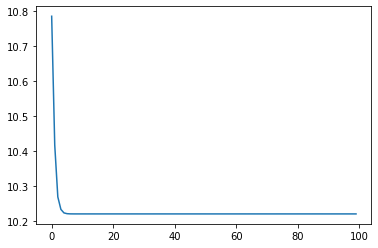

In [33]:
history = model_normal.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

## Compute Test Loss

In [34]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (4063, 50)
Output Test Data: datatype: float64, shape: (4063, 1)

Test Loss: 10.987689971923828


# Combining Algorithms

## Forecasting Training Data

In [146]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (24832, 50)
Output Test Data: datatype: float64, shape: (24832, 1)



In [148]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]

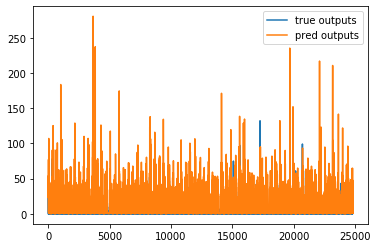

In [149]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()

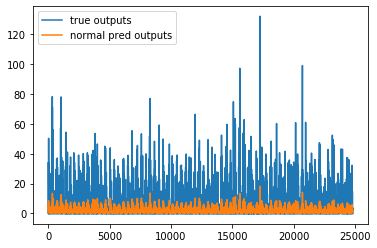

In [150]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

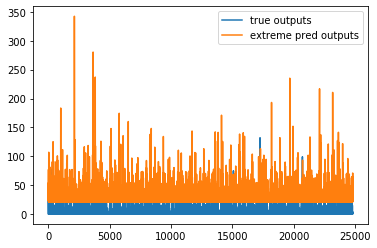

In [151]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

## Forecasting Test Data

In [152]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (2765, 50)
Output Test Data: datatype: float64, shape: (2765, 1)



In [154]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]

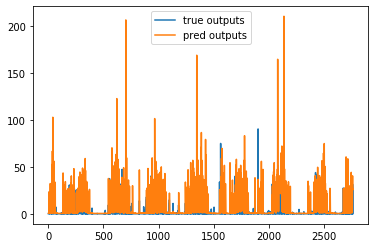

In [155]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()

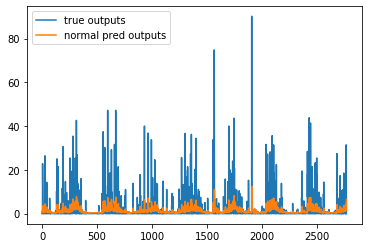

In [156]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

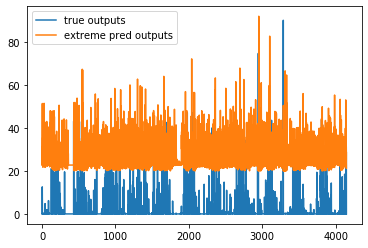

In [44]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()